<a href="https://colab.research.google.com/github/AlexTako/learning/blob/main/Training%20a%20multilayer%20perceptron%20in%20TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Напишите свое решение
!pip install -q seaborn
!pip install tfds-nightly #библиотека tf которая ежедневно пополняется

In [ ]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Установим по умолчанию размер фигуры для Matplotlib по умолчанию.
matplotlib.rcParams['figure.figsize'] = [9, 6]
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
train_data, val_data, test_data = tfds.load("mnist",
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

Размерность исходных данных: (1500, 28, 28, 1)
Размерность данных после сжатия: (1500, 28, 28)


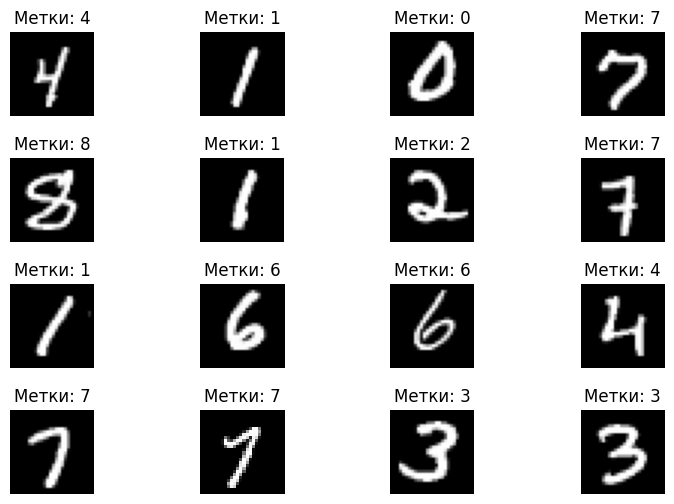

In [ ]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0] # Взять все одним батчем и выбрать его для визуализации
print('Размерность исходных данных:', x_viz.shape)
x_viz = tf.squeeze(x_viz, axis=3) # метод сжатия размерности, исключаем данные по оси с индексом 3
print('Размерность данных после сжатия:', x_viz.shape)

for i in range(16): # Выводим 16 картинок из датасета
    plt.subplot(4,4,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray') # отображение массива numpy как картинки; cmap - карта цветов, используем серую 'gray'
    plt.title(f"Метки: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5, wspace=.5) # Отступы по ширине и высоте между картинками


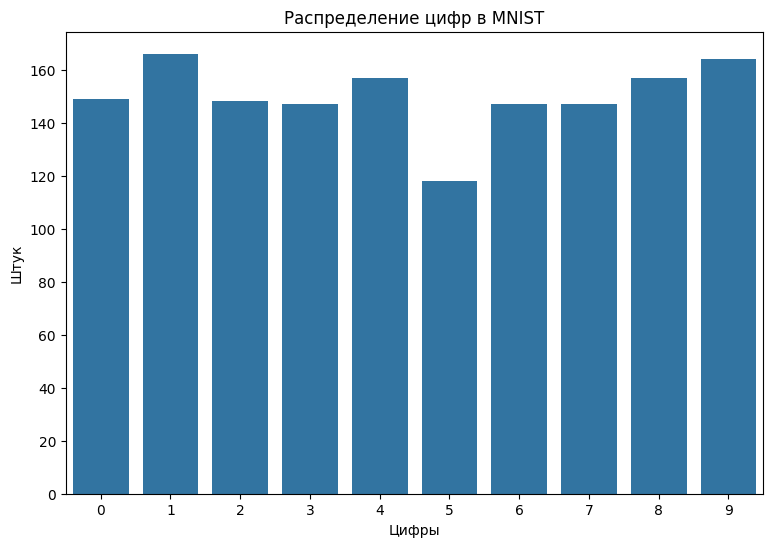

In [ ]:
sns.countplot(x=y_viz.numpy());
plt.xlabel('Цифры')
plt.ylabel('Штук')
plt.title("Распределение цифр в MNIST");

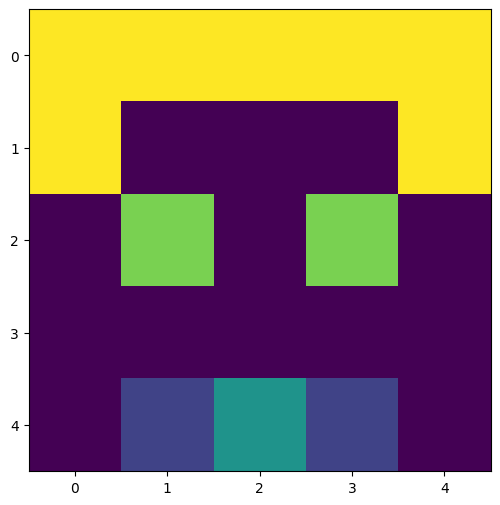

In [ ]:
import numpy as np
face = np.array([
                [250, 250, 250, 250, 250],
                [250,   0,   0,   0, 250],
                [0,   200,   0, 200,   0],
                [0,     0,   0,   0,   0],
                [0,    50, 128,  50,   0],
               ])
plt.imshow(face)

In [ ]:
tf.reshape(face, shape = (1, 25)) # изменяет форму данных, число элементов должно в начальной и конечной форме совпадать 5 х 5 = 1 х 25

<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
array([[250, 250, 250, 250, 250, 250,   0,   0,   0, 250,   0, 200,   0,
        200,   0,   0,   0,   0,   0,   0,   0,  50, 128,  50,   0]])>

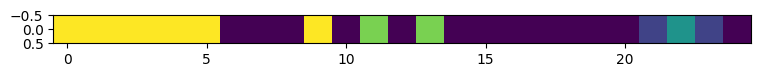

In [ ]:
plt.imshow(tf.reshape(face, shape = (1, 25)))

In [ ]:
# Функция изменения формы и масштабирования данных
def preprocess(x, y):
  # reshap - изменяет форму данных
  x = tf.reshape(x, shape=(-1, 784)) # -1 - значит сохранить форму для заданного индекса матрицы, равносильно указать 1500
  # Масштабируем данные
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess) # map выполняет функцию preprocess для каждого элемента данных, к которым применяется

Text(0.5, 1.0, 'Функция активации ReLU')

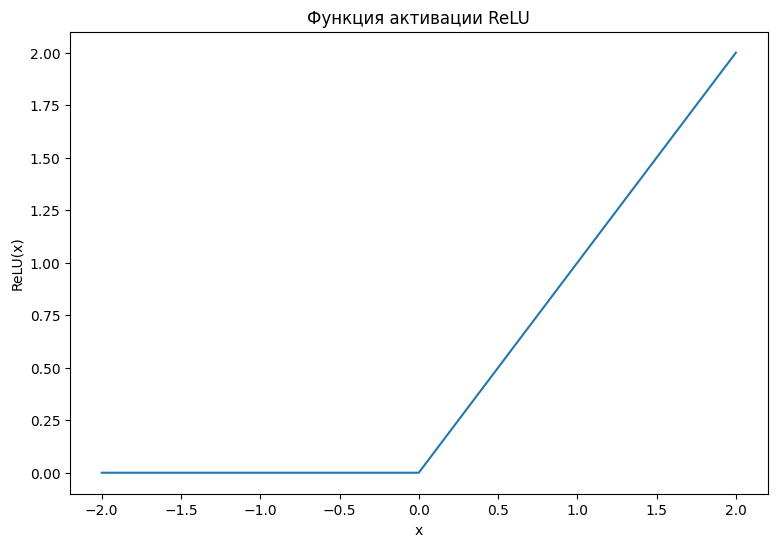

In [ ]:
x = tf.linspace(-2, 2, 201) # Тензорный вариант для linspace
x = tf.cast(x, tf.float32) # Приведение тензора к нужному типу, в данном случае к 32-х разрядному числу с плавающей точкой
plt.plot(x, tf.nn.relu(x))
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('Функция активации ReLU')

Text(0.5, 1.0, 'Функция активации Softmax')

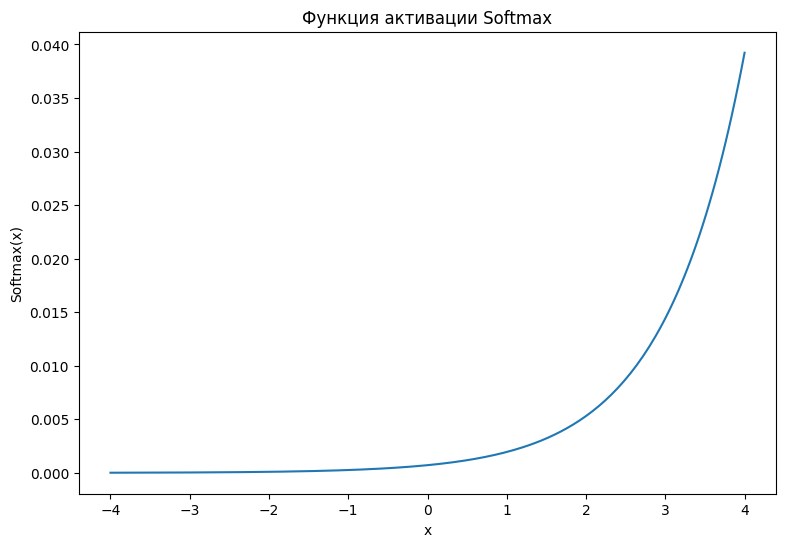

In [ ]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0)) # указываем ось (axis), индекс тензора, по которому проводим вычисления
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Функция активации Softmax')

In [ ]:
def xavier_init(shape):
  # Вычисляем значения инициализации xavier для весовой матрицы
  in_dim, out_dim = shape

  # Задаем диапазон инициализации весов по схеме Ксавье
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))

  # Возвращаем тензор с равномерно распределенными случайными величинами в указанном интервале.
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim),
                                  minval=-xavier_lim, maxval=xavier_lim)
  return weight_vals

In [ ]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Инициализация размеров и функции активации
    self.out_dim = out_dim # Определяем размерность выходов
    self.weight_init = weight_init # Инициализируем веса
    self.activation = activation # Задаем функцию активации
    self.built = False

  @tf.function # Декоратор, который переносит вычисления на уровень графа TensorFlow
  def __call__(self, x):
    if not self.built: # Если запущен первый раз проводим инициализацию
      # Вывод входного измерения на основе первого вызова
      self.in_dim = x.shape[1]
      # Инициализация весов и смещений
      self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim))) # Объявление тензорных переменных
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,))) # Объявление тензорных переменных
      self.built = True # Инициализация пройдена
    # Вычисление прямого прохода
    y = tf.add(tf.matmul(x, self.w), self.b)  # уравнение персептрона
    return self.activation(y) # Применение функции активации к уравнению персептрона

In [ ]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers

  @tf.function # Декоратор, который переносит вычисления на уровень графа TensorFlow
  def __call__(self, x, preds=False):
    # Последовательное выполнение слоев модели
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
hidden_layer_1_size = 700 #в этом блоке добавим 2 слоя
hidden_layer_2_size = 500
hidden_layer_3_size = 300
hidden_layer_4_size = 100
output_size = 10

# Создание модели нейронной сети
mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_3_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_4_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [ ]:
def cross_entropy_loss(y_pred, y):
  # Вычисление перекрестной энтропии с помощью разреженной операции
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce) # аналог np.mean для тензоров

In [ ]:
def accuracy(y_pred, y):
  # Вычисляем точность после извлечения предсказаний класса
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1) # возвращает индекс максимального элемента
  is_equal = tf.equal(y, class_preds) # сравнение тензорных значений
  return tf.reduce_mean(tf.cast(is_equal, tf.float32)) # аналог np.mean для тензоров

In [ ]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Инициализируем параметры оптимизатора и резервируем переменные
      self.beta_1 = beta_1 # гиперпараметр
      self.beta_2 = beta_2 # гиперпараметр
      self.learning_rate = learning_rate # шаг обучения
      self.ep = ep # Эпсилон - предотвращает деление на ноль, слабо влияет на обучение
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False

    def apply_gradients(self, grads, vars):
      # Инициализируем переменные при первом вызове
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Обновите переменные модели с учетом их градиентов
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return

In [ ]:
x = tf.Variable(-2.0)

with tf.GradientTape() as tape:
    y = x ** 2

df = tape.gradient(y, x)
print(df)

tf.Tensor(-4.0, shape=(), dtype=float32)


In [ ]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Обновляем состояние модели с учетом пакета данных
  with tf.GradientTape() as tape:
    y_pred = model(x_batch) # Предсказываем значение с текущими весами
    batch_loss = loss(y_pred, y_batch) # Оцениваем ошибку на текущих весах
  batch_acc = acc(y_pred, y_batch) # Оцениваем точность на текущих весах
  grads = tape.gradient(batch_loss, model.variables) # Вычисляем градиенты
  optimizer.apply_gradients(grads, model.variables) # Обновляем переменные с учетом полученных градиентов
  return batch_loss, batch_acc # Возвращаем ошибку и точность на основе заданного пакета

def val_step(x_batch, y_batch, loss, acc, model):
  # Оцениваем модель на основе заданного пакета валидационных данных без обучения на текущих весах
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [ ]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Инициализация структур данных
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Отформатируем тренировочный цикл и начнем обучение
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Выполняем итерацию по обучающим данным
    for x_batch, y_batch in train_data:
      # Вычисляем градиенты и обновляем параметры модели
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Следим за результатами обучения на пакетном уровне
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Повторяем процедуру проверки данных
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Следим за производительностью модели на уровне эпохи
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Эпоха: {epoch}")
    print(f"Обучающая ошибка: {train_loss:.3f}, Обучающая точность: {train_acc:.3f}")
    print(f"Валидационная ошибка: {val_loss:.3f}, Валидационная точность: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Эпоха: 0
Обучающая ошибка: 0.236, Обучающая точность: 0.930
Валидационная ошибка: 0.114, Валидационная точность: 0.967
Эпоха: 1
Обучающая ошибка: 0.091, Обучающая точность: 0.972
Валидационная ошибка: 0.106, Валидационная точность: 0.969
Эпоха: 2
Обучающая ошибка: 0.057, Обучающая точность: 0.982
Валидационная ошибка: 0.122, Валидационная точность: 0.968
Эпоха: 3
Обучающая ошибка: 0.043, Обучающая точность: 0.987
Валидационная ошибка: 0.103, Валидационная точность: 0.974
Эпоха: 4
Обучающая ошибка: 0.036, Обучающая точность: 0.988
Валидационная ошибка: 0.102, Валидационная точность: 0.975
Эпоха: 5
Обучающая ошибка: 0.031, Обучающая точность: 0.990
Валидационная ошибка: 0.116, Валидационная точность: 0.971
Эпоха: 6
Обучающая ошибка: 0.026, Обучающая точность: 0.992
Валидационная ошибка: 0.137, Валидационная точность: 0.969
Эпоха: 7
Обучающая ошибка: 0.023, Обучающая точность: 0.993
Валидационная ошибка: 0.102, Валидационная точность: 0.978
Эпоха: 8
Обучающая ошибка: 0.018, Обучающая точн

Делаем вывод что время обучения увеличивается, точность растет незначительно, а к 7 эпохе становится практически одинаковой